# Fixed Income Derivatives - Curve Fitting Example
Assume you have the following market data available where the interest rate swaps pay 6M EURIBOR semiannually against a fixed rate paid annually
$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{EURIBOR} & \textbf{Fixing} & \textbf{FRA} & \textbf{Midquote} & \textbf{IRS} & \textbf{Midquote} \\
\hline
6\text{M} & 0.03478 & 1\text{X}7 & 0.03743 & 2\text{Y} & 0.04377 \\
          &         & 2\text{X}8 & 0.03871 & 3\text{Y} & 0.04625 \\
          &         & 3\text{X}9 & 0.03989 & 4\text{Y} & 0.04777 \\
          &         & 4\text{X}10 & 0.04098 & 5\text{Y} & 0.04875 \\
          &         & 5\text{X}11 & 0.04198 & 7\text{Y} & 0.04992 \\
          &         & 6\text{X}12 & 0.04289 & 10\text{Y} & 0.05081 \\
          &         & 7\text{X}13 & 0.04374 & 15\text{Y} & 0.05148 \\
          &         & 8\text{X}14 & 0.04452 & 20\text{Y} & 0.05181 \\
          &         & 9\text{X}15 & 0.04524 & 30\text{Y} & 0.05211 \\
\hline
\end{array}
$$

In [1]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import sys
import os
# add the directory
sys.path.append(os.path.abspath("../../Files"))

import numpy as np
from scipy.optimize import minimize

# import own module
import fixed_income_derivatives_E2024 as fid
import plotting as plot

%load_ext autoreload
%autoreload 2

## Problem 1 - Fitting the yield curve

#### (a) Discuss what properties the term structure of the short rate and the term structure of the instantaneous forward rate should have after fitting a term structure to market data.

We would in genral like the term structure of the short rate and forward rate to be postive and smooth. The forward rate is the derivative of the short rate, hence the short rate must be differentiable. This is a requirement for all our models (Vasicek, CIR, Ho-Lee and Hull-White).

If we fit to the Ho-Lee or Hull-White model we require the forward rates to be smooth and differentiable as well as this is a requirement for these models but not for Vasicek and CIR.

#### (b) Fit a zero coupon bond spot rate curve to the market data above using different techniques and discuss which fit is better in terms of the criteria from (a)

In terms of smoothness and differentiability, the Nelson-Siegel fit is often the best choice as it produces a smooth and differentiable curve by construction, due to its parametric form that is explicitly designed for yield curve modeling. 

The Hermite fit, depending on the degree $K$, can provide a smooth curve, but higher degrees may introduce oscillations (Runge's phenomenon), compromising stability and interpretability. 

The linear fit, while simple, lacks differentiability at the points where line segments meet, making it unsuitable when smoothness and differentiability are critical. 

Therefore, Nelson-Siegel is generally the preferred method for fitting a yield curve under these criteria. In addition we will prefer the smooth transition mode of the interpolation method.

In [2]:
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03478}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03743},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03871},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03989},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04098},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.04198},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.04289},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.04374},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.04452},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.04524}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.04377, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04625, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04777, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04875, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04992, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05081, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05148, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05181, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05211, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

In [3]:
resolution = 2 # points per year
# testing different interpolation methods
inter_options =[
                {"method":"linear","transition":None},
                {"method":"linear","transition":"smooth"},
                {"method":"nelson_siegel","transition": None},
                {"method":"hermite","degree":2,"transition":"smooth"},
                {"method":"hermite","degree":2,"transition":None},
                {"method":"nelson_siegel","transition": 'smooth'},
                ]
p_inters = []
f_inters = []

for i, inter in enumerate(inter_options):
    T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options =inter)
    T_res = np.array([i*(1/resolution) for i in range(0,int(T_fit[-1])*resolution + 1)])
    p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter=T_res,T=T_fit,R=R_fit,interpolation_options = inter)
    p_inters.append(p_inter)
    f_inters.append(f_inter)

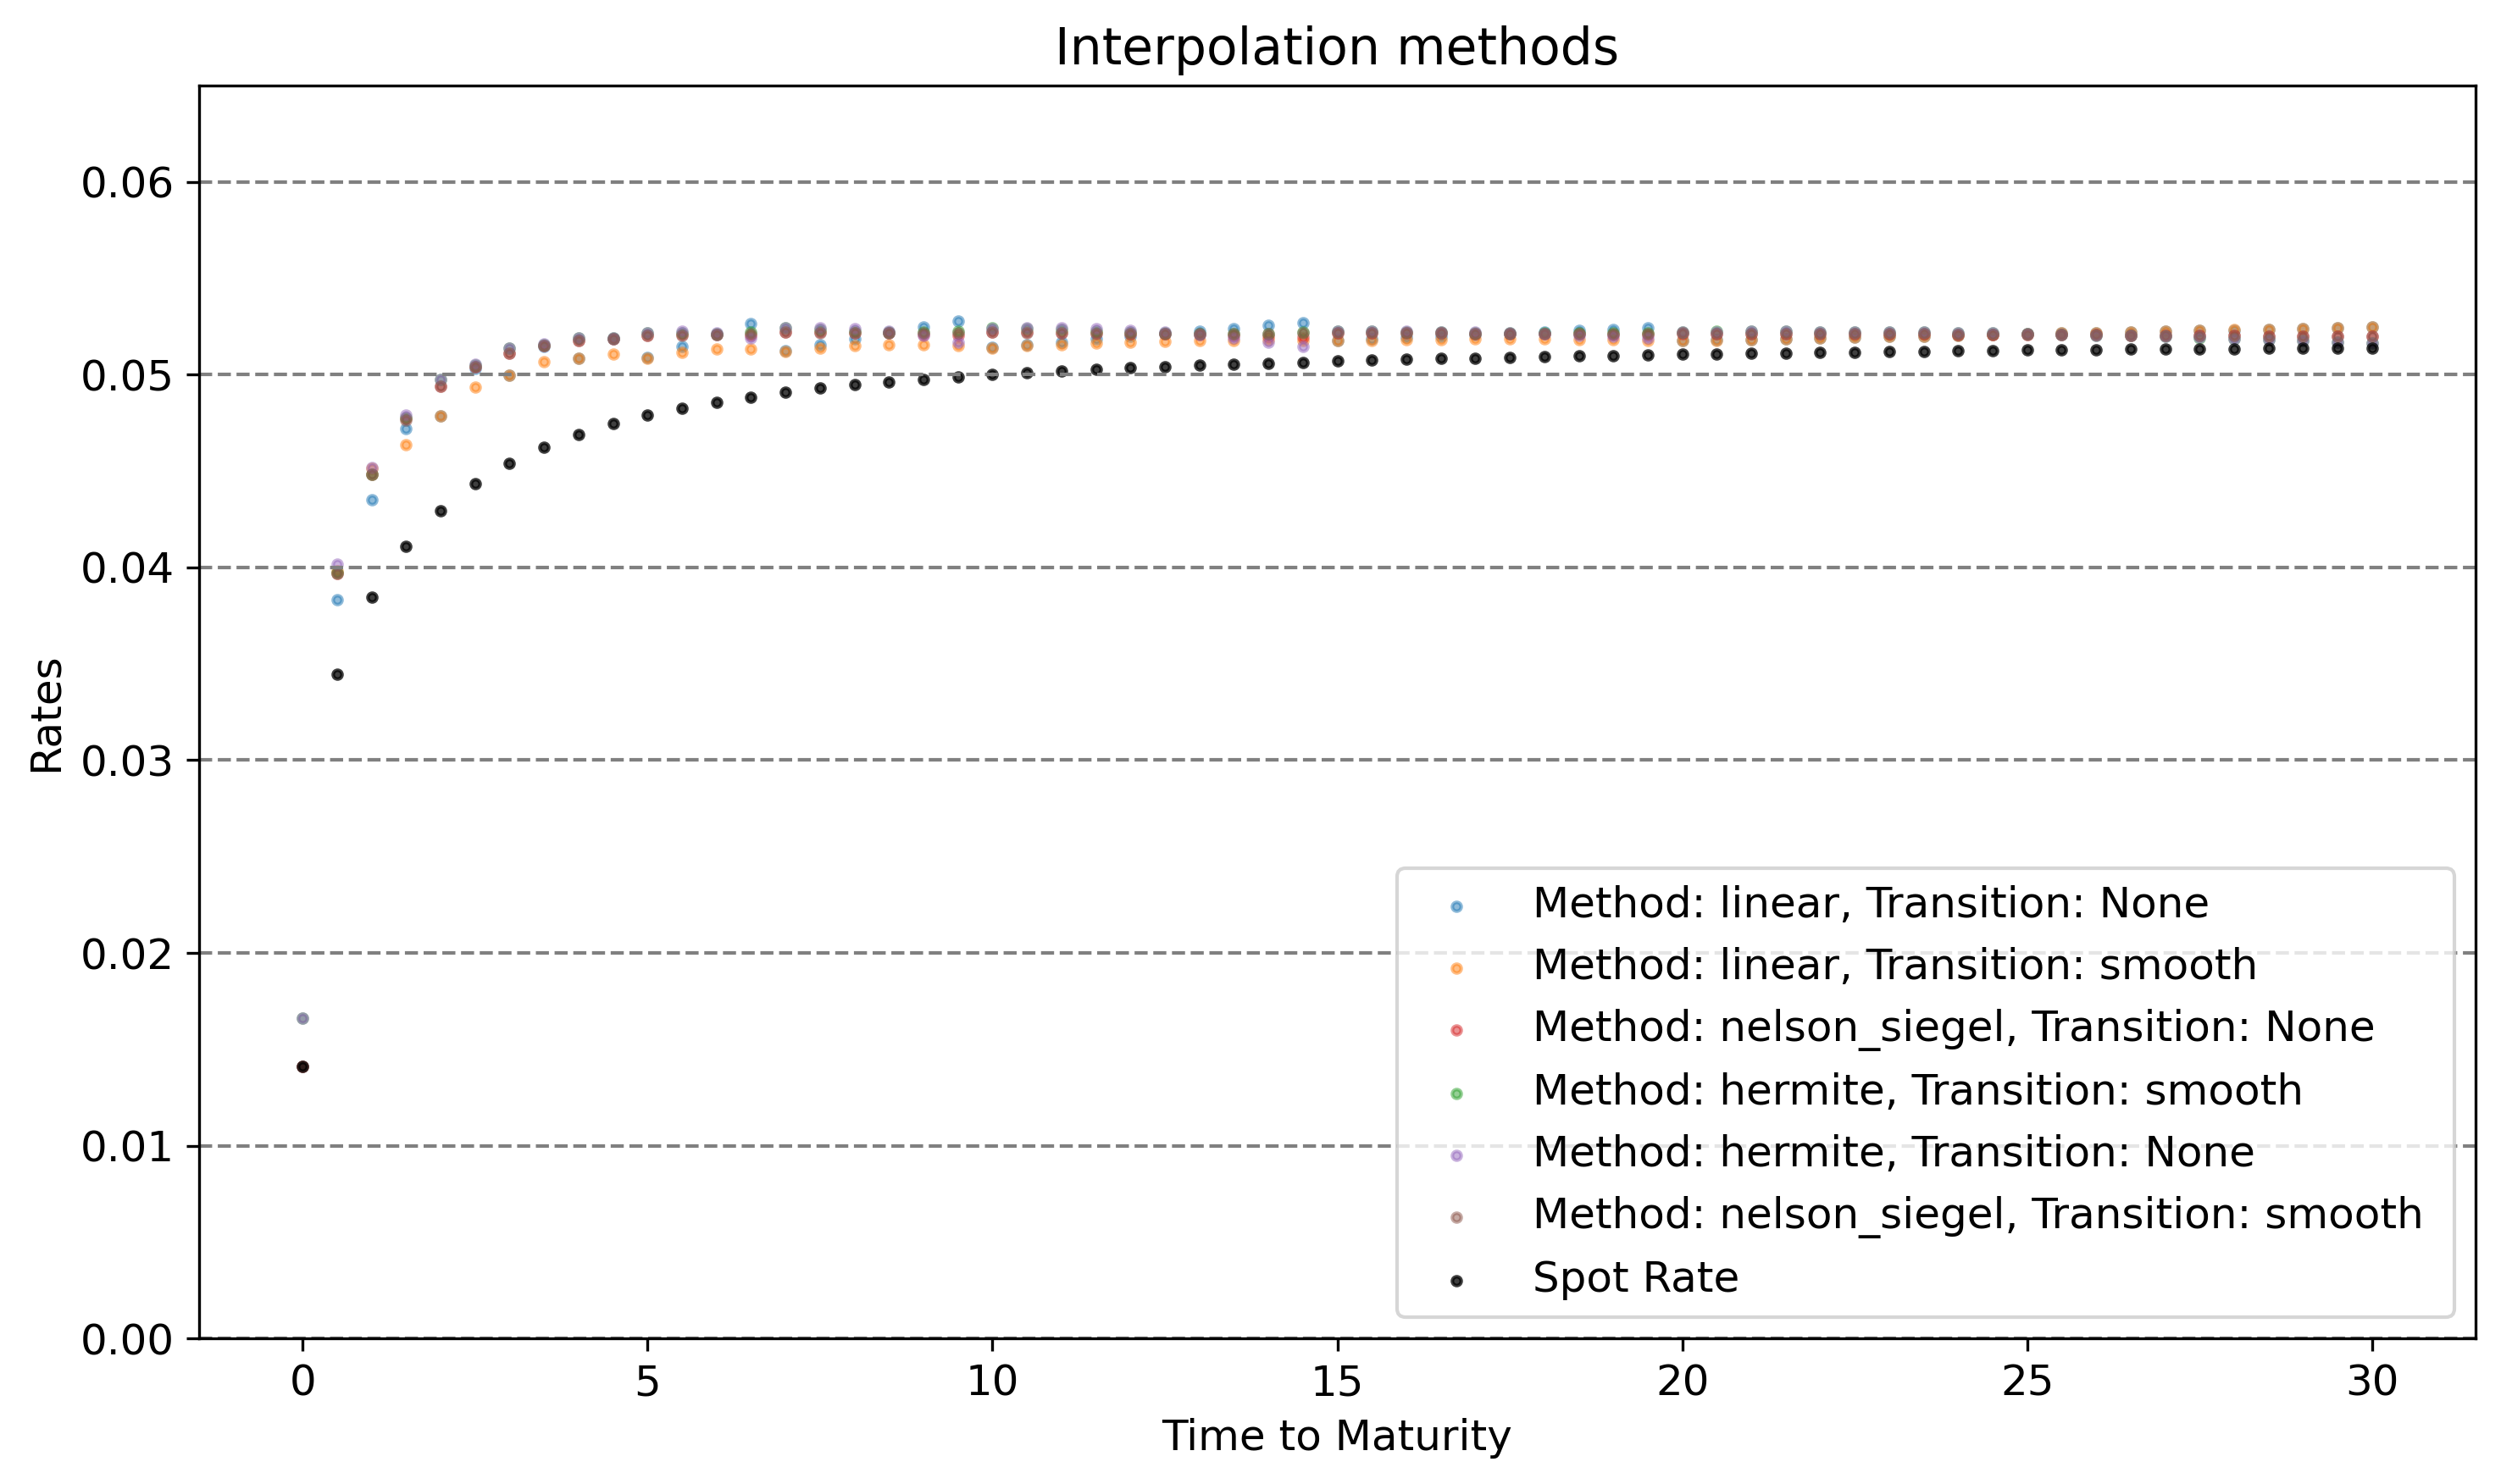

In [4]:
fits = [{'label':f'Method: {inter_options[i]["method"]}, Transition: {inter_options[i]["transition"]}', 'x':T_inter, 'y':f_inters[i], 's':25, 'alpha':0.5} for i in range(len(inter_options))]
fits.append({'label':'Spot Rate', 'x':T_inter, 'y':R_inter,'color':'black','s':25})

plot.rates(fits,title='Interpolation methods')

#### (c) Plot the term structures of spot rates, instantaneous forward rates and par swap rates implied by the fitted ZCB term structure.

In [5]:
# preferred interpolation method
interpolation_options = {"method":"nelson_siegel","transition": 'smooth'}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options =interpolation_options)
T_res = np.array([i*(1/resolution) for i in range(0,int(T_fit[-1])*resolution + 1)])

p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter=T_res,T=T_fit,R=R_fit,interpolation_options = interpolation_options)

In [6]:
T_swap = np.array([i for i in range(1,31)]) # calculating yearly swap rates
R_swap, S_swap = np.zeros([len(T_swap)]), np.zeros([len(T_swap)])
for i, maturity in enumerate(T_swap):
    R_swap[i], S_swap[i] = fid.swap_rate_from_zcb_prices(0,0,T_swap[i],"annual",T_inter,p_inter)
print(f"10Y par swap rate: {R_swap[9]}, accrual factor: {S_swap[9]}")

10Y par swap rate: 0.050810085651516936, accrual factor: 7.743714699074263


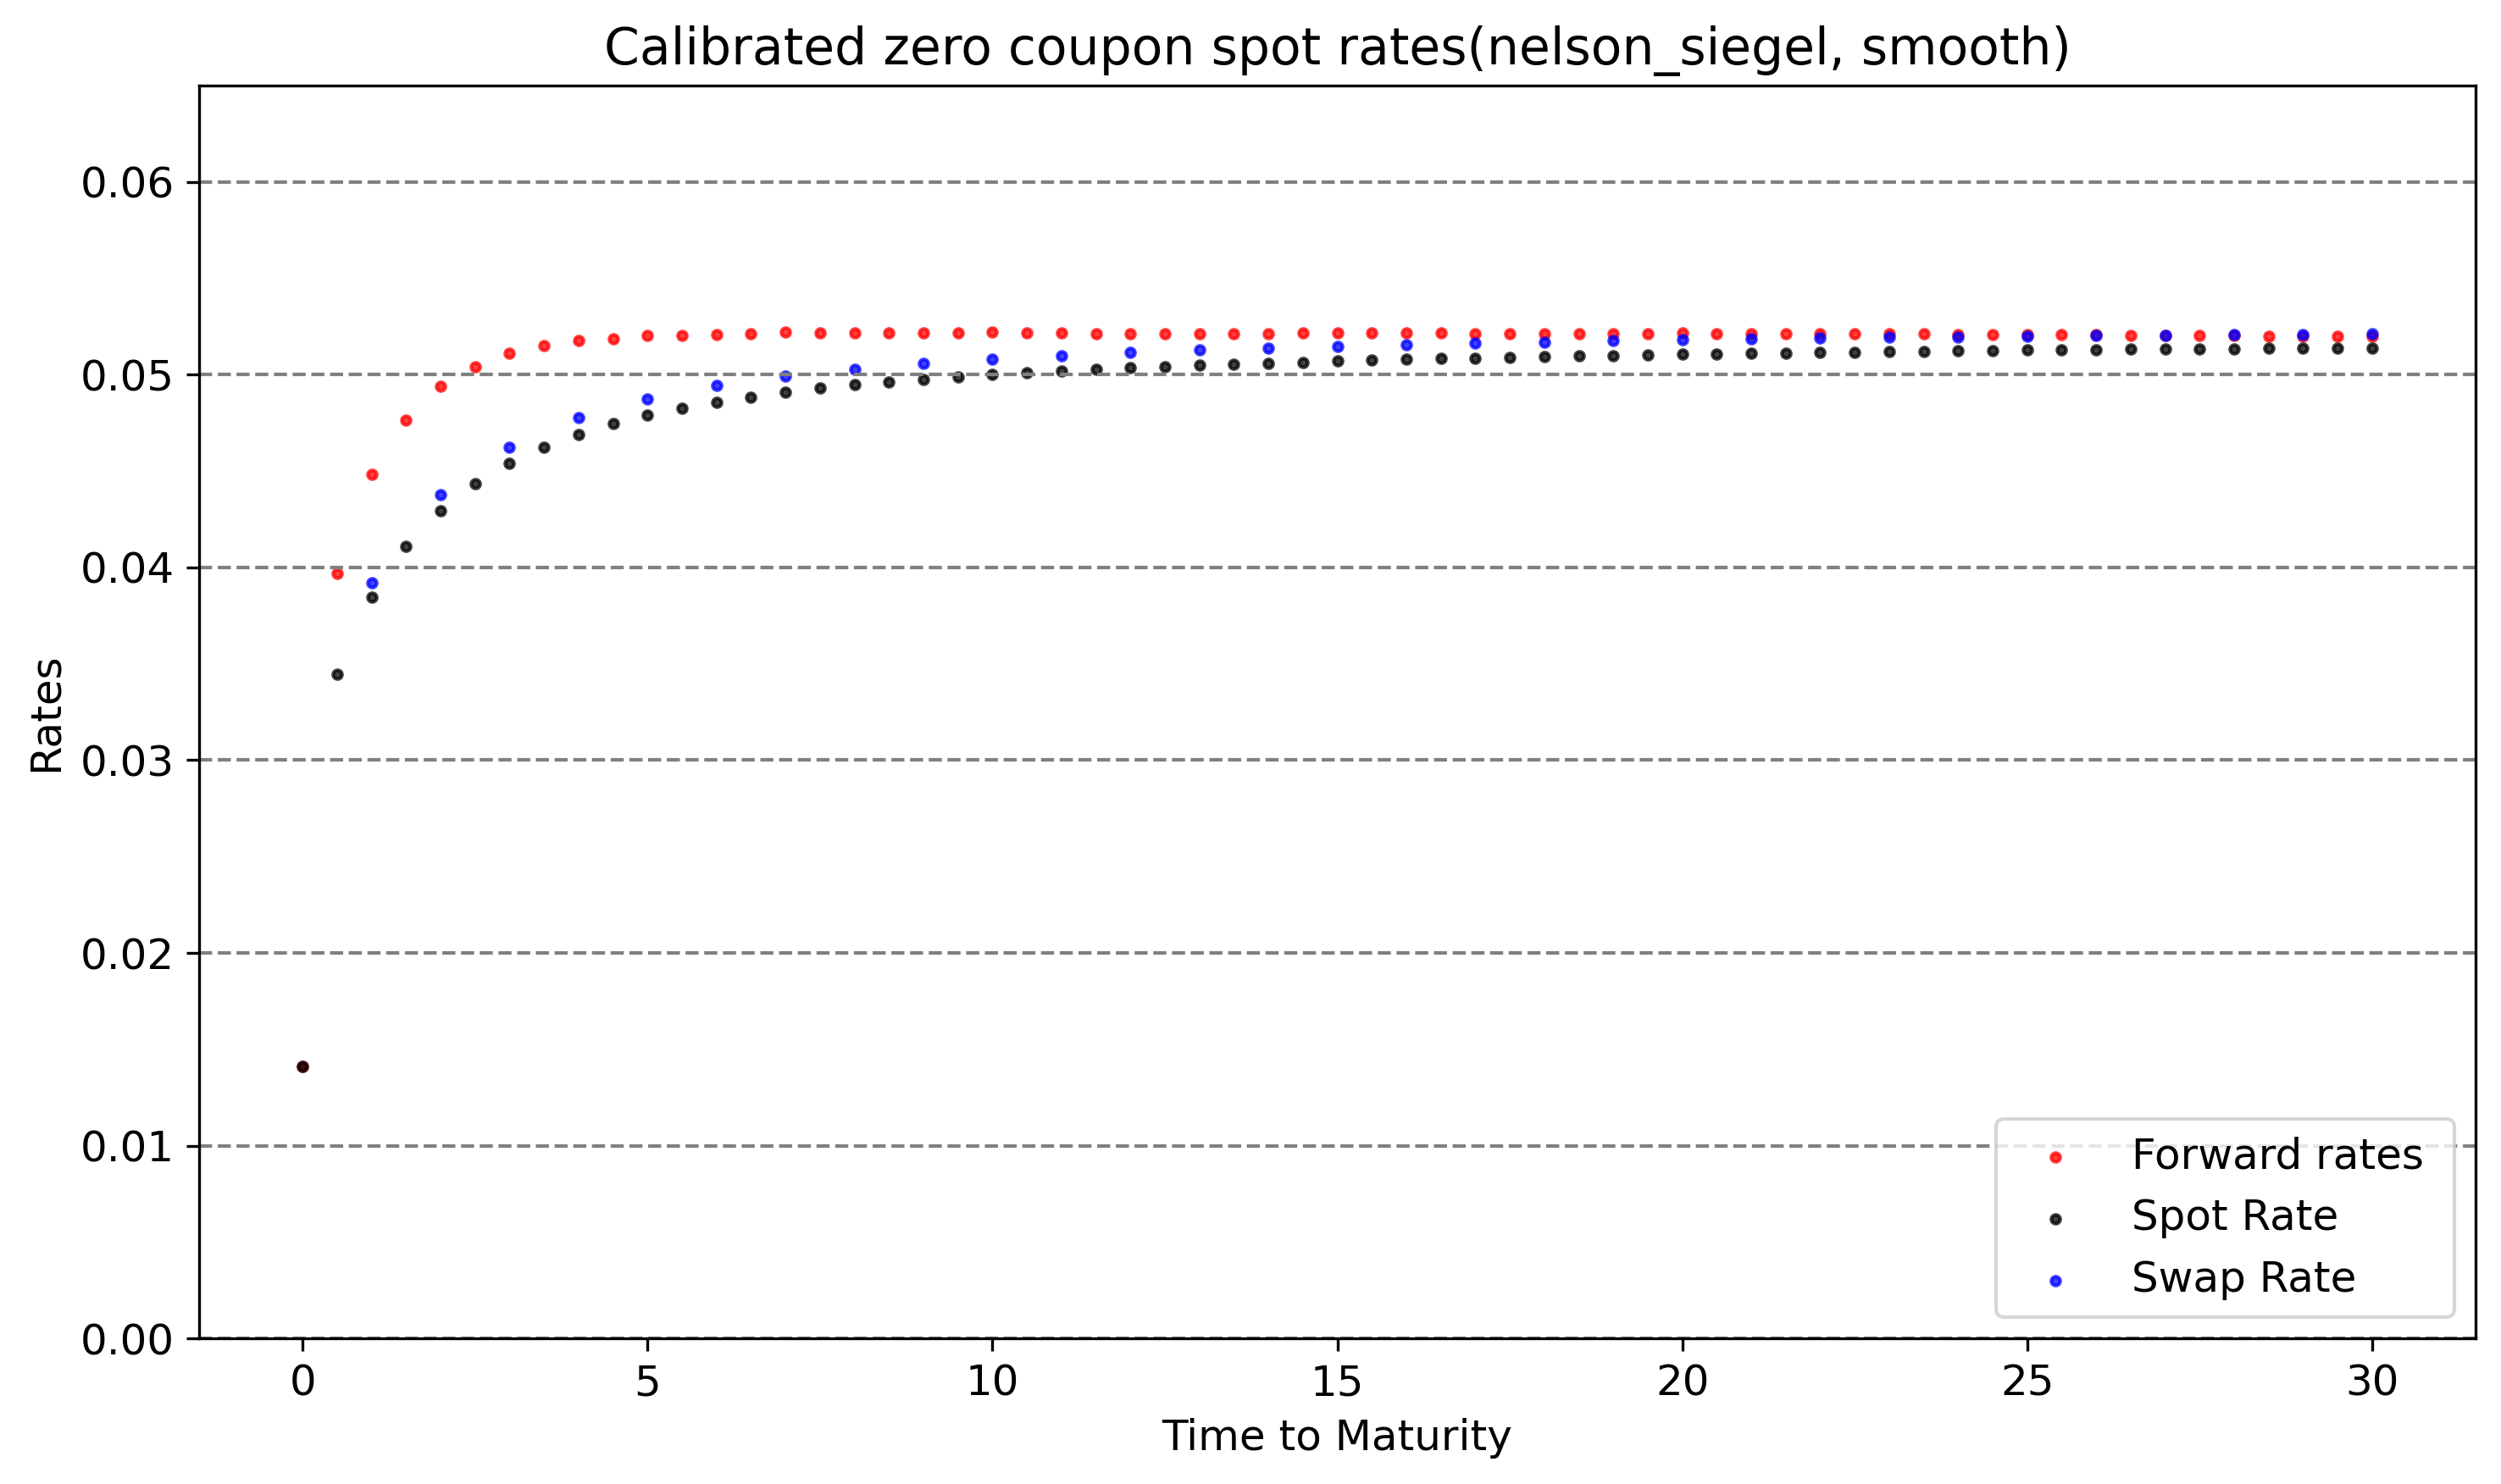

In [7]:
fit = [{'label':'Forward rates', 'x':T_inter, 'y':f_inter, 's':25,'color':'red'},
       {'label':'Spot Rate', 'x':T_inter, 'y':R_inter,'color':'black','s':25},
       {'label':'Swap Rate', 'x':T_swap, 'y':R_swap,'color':'blue','s':25}]

plot.rates(fit,title=f'Calibrated zero coupon spot rates({interpolation_options["method"]}, {interpolation_options["transition"]})')

## Problem 2 - Bumping spot rates and finding the DV01 of a swap
Next, we will use the ZCB term structure for risk management and compute the DV01 (Dollar Value of 01 basis point) of a 10Y payer swap when spot rates are bumped by 1 bps up and down.

#### (a) Bump each of the spot rates for $T \in [1,2,...,10]$ by $1$ bp up and down

In [8]:
# Problem 2 - Bumping spot rates and finding the DV01 of a swap
swap_id, size_bump = 15, 0.0001 # index of the 10Y swap, and bump size

def dv01_swap_spot_rate_bump_fct(t,T_n,T_N,fixed_freq,R_swap_init,T_bump,size_bump,T_inter,R_inter,p_inter):
    R_bump, p_bump = fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
    R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(t,T_n,T_N,fixed_freq,T_inter,p_bump)
    DV01 = (R_swap_bump-R_swap_init)*S_swap_bump
    return DV01

In [9]:
# 2a) DV01 when bumping a single spot rate exampl3 to ensure the function works
idx_bump_single = 20 # index of the spot rate to bump
R_bump = R_inter.copy()
R_bump[idx_bump_single] += size_bump
p_bump = fid.zcb_prices_from_spot_rates(T_inter,R_bump)
R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,data[swap_id]["maturity"],"annual",T_inter,p_bump)
print(f"R_swap_bump: {R_swap_bump}, S_swap_bump: {S_swap_bump}")
DV01 = (R_swap_bump-data[swap_id]["rate"])*S_swap_bump
print(f"Dollar Value of 01 Basis Point for swap {swap_id} when bumping spot_rate for T: {T_inter[idx_bump_single]} is: {10000*DV01}")

R_swap_bump: 0.05089235765279956, S_swap_bump: 7.743108461050916
Dollar Value of 01 Basis Point for swap 15 when bumping spot_rate for T: 10.0 is: 6.37704238224533


In [10]:
# 2a) DV01 for bumping each of the spot rates at T=[1,2,3,4,5,6,7,8,9,10]
DV01_bump = np.zeros([10])
T_bump = np.array([i for i in range(1,11)])
for i, val in enumerate(T_bump):
    DV01_bump[i] = dv01_swap_spot_rate_bump_fct(0,0,data[swap_id]["maturity"],"annual",data[swap_id]["rate"],val,size_bump,T_inter,R_inter,p_inter)
print(f"DV01 when bumping each spot rate separately: {10000*DV01_bump}")

DV01 when bumping each spot rate separately: [0.05552317 0.09988121 0.13963658 0.17506599 0.20652785 0.2343395
 0.25879266 0.28015892 0.29871514 6.37704238]


#### (b) Bump all of the spot rates for $T \in [1,2,...,10]$ by $1$ bp up and down

In [11]:
# 2b) DV01 for bumping all of the spot rates at T=[1,2,3,4,5,6,7,8,9,10]
R_bump, p_bump = fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,data[swap_id]["maturity"],"annual",T_inter,p_bump)
print(f"R_swap_bump: {R_swap_bump}, S_swap_bump: {S_swap_bump}")
DV01 = (R_swap_bump-data[swap_id]["rate"])*S_swap_bump
print(f"Dollar Value of 01 Basis Point for swap {swap_id} when bumping spot_rates for T: {T_bump} is: {10000*DV01}")

R_swap_bump: 0.05091421465885852, S_swap_bump: 7.739784415503275
Dollar Value of 01 Basis Point for swap 15 when bumping spot_rates for T: [ 1  2  3  4  5  6  7  8  9 10] is: 8.065989925001757


#### (c) Discuss which of the spot rates that influences the DV01 of the 10Y swap the most and interpret your result.

The DV01 of a 10-year payer swap is most influenced by spot rates near the 10-year maturity. This is because longer-term spot rates significantly affect the discount factors applied to the swap's cash flows, especially those occurring closer to the swap's maturity. Consequently, changes in long-term rates have the largest impact on the swap’s value, reflecting its sensitivity to the tail of the yield curve.

#### (d) Redo a)-c) for the 5Y interest rate swap

In [12]:
swap_id_5Y = 13
DV01_bump_5Y = np.zeros([5])
T_bump_5Y = np.array([i for i in range(1,6)])
for i, val in enumerate(T_bump_5Y):
    DV01_bump_5Y[i] = dv01_swap_spot_rate_bump_fct(0,0,data[swap_id_5Y]["maturity"],"annual",data[swap_id_5Y]["rate"],val,size_bump,T_inter,R_inter,p_inter)
print(f"DV01 when bumping each spot rate separately: {10000*DV01_bump_5Y}")

DV01 when bumping each spot rate separately: [0.03946765 0.08202727 0.12017083 0.15416382 4.11852145]


In [13]:
R_bump_5Y, p_bump_5Y = fid.spot_rate_bump(T_bump_5Y,size_bump,T_inter,R_inter,p_inter)
R_swap_bump_5Y, S_swap_bump_5Y = fid.swap_rate_from_zcb_prices(0,0,data[swap_id_5Y]["maturity"],"annual",T_inter,p_bump_5Y)
print(f"R_swap_bump: {R_swap_bump_5Y}, S_swap_bump: {S_swap_bump_5Y}")
DV01 = (R_swap_bump_5Y-data[swap_id_5Y]["rate"])*S_swap_bump_5Y
print(f"Dollar Value of 01 Basis Point for swap {swap_id_5Y} when bumping spot_rates for T: {T_bump_5Y} is: {10000*DV01}")

R_swap_bump: 0.048854047542168565, S_swap_bump: 4.3673438735296255
Dollar Value of 01 Basis Point for swap 13 when bumping spot_rates for T: [1 2 3 4 5] is: 4.544113958456889


## Problem 3 - Bumping market rates and finding the DV01 of a swap
Finally, we will investigate the sensitivity of a 10 Y payer swap to changes in market rates by bumping
these up and down also by one bps.

#### (a) Bump each of the market rates for the EURIBOR fixing, the FRAs and the interest rate swaps by 1 bp up and down.

In [14]:
# Problem 3 - Bumping market rates and finding the DV01 of a swap
def dv01_market_rate_bump_fct(t,T_n,T_N,T_inter,fixed_freq,R_swap_init,idx_bump,size_bump,data,interpolation_options):
    p_bump, R_bump, f_bump, T_bump, data_bump = fid.market_rate_bump(idx_bump,size_bump,T_inter,data,interpolation_options = interpolation_options)
    R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,T_N,fixed_freq,T_bump,p_bump)
    DV01 = (R_swap_bump-R_swap_init)*S_swap_bump
    return DV01

In [15]:
# DV01 when bumping a single market rate example to ensure the function works
idx_bump_single = 15 # index of the market rate to bump
p_bump, R_bump, f_bump, T_bump, data_bump = fid.market_rate_bump(idx_bump_single,size_bump,T_inter,data,interpolation_options = interpolation_options)
R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,data[swap_id]["maturity"],"annual",T_inter,p_bump)
print(f"R_swap_bump: {R_swap_bump}, S_swap_bump: {S_swap_bump}")
DV01 = (R_swap_bump-data[swap_id]["rate"])*S_swap_bump
print(f"DV01 for swap {swap_id} when bumping market rates for idx: {idx_bump_single} is: {10000*DV01}")

R_swap_bump: 0.05090964093449375, S_swap_bump: 7.7422350289033295
DV01 for swap 15 when bumping market rates for idx: 15 is: 7.714435333501831


In [16]:
# DV01 when bumping each of the market rates
idx_bump_all = np.array([i for i in range(0,19)]) # 19 market instruments
DV01_bump = np.zeros([19])
for i, idx in enumerate(idx_bump_all):
    DV01_bump[i] = dv01_market_rate_bump_fct(0,0,data[swap_id]["maturity"],T_inter,"annual",data[swap_id]["rate"],idx,size_bump,data,interpolation_options)
print(f"DV01 for the 10Y swap when bumping each market rate separately: {10000*DV01_bump}")

DV01 for the 10Y swap when bumping each market rate separately: [ 3.37388137e-03  6.63260911e-03  6.63260911e-03  6.63260911e-03
  6.63260911e-03  6.63260911e-03  3.27850022e-03  6.63260911e-03
  6.63260911e-03  6.63260911e-03  6.86312794e-02  8.01927075e-03
  9.71141835e-03 -5.76435369e-02  1.49462015e-02  7.71443533e+00
 -9.73128286e-03  4.07890339e-02 -4.68451864e-03]


#### (b) Bump all of the market rates by 1 bp up and down.

In [17]:
# DV01 when bumping all of the market rates
p_bump, R_bump, f_bump, T_bump, data_bump = fid.market_rate_bump(idx_bump_all,size_bump,T_inter,data,interpolation_options = interpolation_options)
R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,data[swap_id]["maturity"],"annual",T_inter,p_bump)
print(f"R_swap_bump: {R_swap_bump}, S_swap_bump: {S_swap_bump}")
DV01 = (R_swap_bump-data[swap_id]["rate"])*S_swap_bump
print(f"DV01 for the 10Y swap (id {swap_id}) when bumping spot_rates for idx: {idx_bump_all} is: {10000*DV01}")

R_swap_bump: 0.05090994735114049, S_swap_bump: 7.739933580128696
DV01 for the 10Y swap (id 15) when bumping spot_rates for idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] is: 7.735858593371752


#### (c) Discuss which of the market rates that influences the DV01 of the 10Y swap the most and interpret your result.

The DV01 of the 10-year payer swap is most influenced by changes in the market rates corresponding to the 10-year IRS midquote and, to a lesser extent, nearby maturities such as the 7-year and 15-year IRS midquotes. This is because these rates directly anchor the swap's fixed leg cash flows and determine the discount factors applied to the 10-year cash flows.

Interpretation:
- The 10-year IRS midquote has the greatest impact as it directly reflects market expectations for rates at the swap's maturity and determines the fixed rate of the swap.
- Nearby rates (e.g., 7-year or 15-year) also influence DV01 because changes in the slope of the yield curve near 10 years affect the swap valuation.
- FRAs and short-term rates (e.g., 6M EURIBOR) have less impact since they primarily influence the floating leg, which resets regularly and offsets rate changes over time.

This result highlights the strong sensitivity of the swap's DV01 to the long-term portion of the yield curve, emphasizing the importance of managing risks in these maturities.

#### (d) Redo a)-c) for the 5Y interest rate swap

In [18]:
DVO1_bump_5Y = np.zeros([19])
for i, idx in enumerate(idx_bump_all):
    DVO1_bump_5Y[i] = dv01_market_rate_bump_fct(0,0,data[swap_id_5Y]["maturity"],T_inter,"annual",data[swap_id_5Y]["rate"],idx,size_bump,data,interpolation_options)
print(f"DV01 for the 5Y swap when bumping each market rate separately: {10000*DVO1_bump_5Y}")

DV01 for the 5Y swap when bumping each market rate separately: [ 3.22525945e-02 -7.44073294e-03 -7.44073294e-03 -7.44073294e-03
 -7.44073294e-03 -7.44073294e-03  3.21610804e-02 -7.44073294e-03
 -7.44073294e-03 -7.44073294e-03 -4.22081308e-02  8.07630022e-04
 -9.39095390e-03  4.36965017e+00 -1.81120979e-02 -1.01776811e-02
  9.84123834e-03 -2.28155492e-02 -5.31858158e-03]


In [19]:
p_bump_5Y, R_bump_5Y, f_bump_5Y, T_bump_5Y, data_bump_5Y = fid.market_rate_bump(idx_bump_all,size_bump,T_inter,data,interpolation_options = interpolation_options)
R_swap_bump_5Y, S_swap_bump_5Y = fid.swap_rate_from_zcb_prices(0,0,data[swap_id_5Y]["maturity"],"annual",T_inter,p_bump_5Y)
print(f"R_swap_bump: {R_swap_bump_5Y}, S_swap_bump: {S_swap_bump_5Y}")
DV01 = (R_swap_bump_5Y-data[swap_id_5Y]["rate"])*S_swap_bump_5Y
print(f"DV01 for the 5Y swap (id {swap_id_5Y}) when bumping spot_rates for idx: {idx_bump_all} is: {10000*DV01}")

R_swap_bump: 0.04885073295382136, S_swap_bump: 4.3673939491298155
DV01 for the 5Y swap (id 13) when bumping spot_rates for idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] is: 4.399404929973868


## Problem 4 - Mark-to-market
In this problem, you will compute the mark-to-market value of three different swap related derivatives and compute the PnL of each position since inception.

#### (a) Compute the market value of a $7Y$ swap with a notional of $1$ entered into a year ago at the swap rate $0.048$. Also, compute the PnL of this position.
*Notes: If we have price or implied volatility we can price a swaption using Blacks Formula, else we have to simulate the short rate until the maturity to find ZCB prices and calculate the payer swaption*

In [20]:
T_pos, R_pos = 6, 0.048
R_swap_pos, S_swap_pos = fid.swap_rate_from_zcb_prices(0,0,T_pos,"annual",T_inter,p_inter) # finding the swap rate for the position today #(time now, time start, time end, fixed freq, maturities for zcb, zcb prices)
PnL = (R_swap_pos-R_pos)*S_swap_pos
print(f"6Y par swap rate: {R_swap_pos}, S_swap: {S_swap_pos},\nPnL of position in 7Y payer swap after one year: {10000*PnL} in bps.")

6Y par swap rate: 0.049426327217177, S_swap: 5.115757211050895,
PnL of position in 7Y payer swap after one year: 72.96743746591378 in bps.


#### (b) Compute the market value of a $1Y6Y$ payer swaption also with a notional of one entered into exactly one year ago at the then at-the-money strike of $0.048$. Also compute the PnL of this position if the initial cost of the swaption was $38$ bps
*Note: 1Y6Y - exercise 1 year from now, underlying is a 6 year payer swap. Swaption is a regular call option. At exercise it is just the diff between swap rate and spot rate*

In [21]:
swaption_price = 38  # price in bps
print(f"Market value of payer swaption now at exercise: {10000*PnL},\nPnL of position in swaption: {10000*PnL-swaption_price}.")

Market value of payer swaption now at exercise: 72.96743746591378,
PnL of position in swaption: 34.967437465913775.


#### (c) Compute the market value of a $5Y5Y$ forward receiver swap with a notional of $1$ entered into exactly two years ago at the then $5Y5Y$ par forward swap rate of $0.051$. Also compute the PnL of this position.

In [22]:
T_n, T_N, R_pos2 = 3, 8, 0.051
R_swap_pos2, S_swap_pos2 = fid.swap_rate_from_zcb_prices(0,T_n,T_N,"annual",T_inter,p_inter)
PnL2 = (R_pos2 - R_swap_pos2)*S_swap_pos2
print(f"3Y5Y forward par swap rate: {R_swap_pos2}, S_swap_pos: {S_swap_pos2},\nPnL of position in : {10000*PnL2}.")

3Y5Y forward par swap rate: 0.05326536757948229, S_swap_pos: 3.745488842567487,
PnL of position in : -84.84908993265043.


## Problem 5 - Fitting a Vasicek model to the yield curve
In this problem, we will fit the Vasicek model to our yield curve data

#### (a) Use the initial values $r_0= 0.03$, $a = 0.5$, $b = 0.04$ and $\sigma = 0.03$ to fit a Vasicek model to your ZCB spot rate curve

In [23]:
param_0 = 0.03, 0.5, 0.04, 0.03
result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")
r0, a, b, sigma = result.x
p_vasicek = fid.zcb_price_vasicek(r0,a,b,sigma,T_inter)
f_vasicek = fid.forward_rate_vasicek(r0,a,b,sigma,T_inter)
R_vasicek = fid.spot_rate_vasicek(r0,a,b,sigma,T_inter)

Parameters from the fit: [ 0.01410681  1.09188608  0.0875189  -0.25872177]. SSE of the fit: 9.897548158608053e-08


#### (b) Plot the fitted spot rates in your Vasicek model in the same plot as your ZCB spot and forward rates.

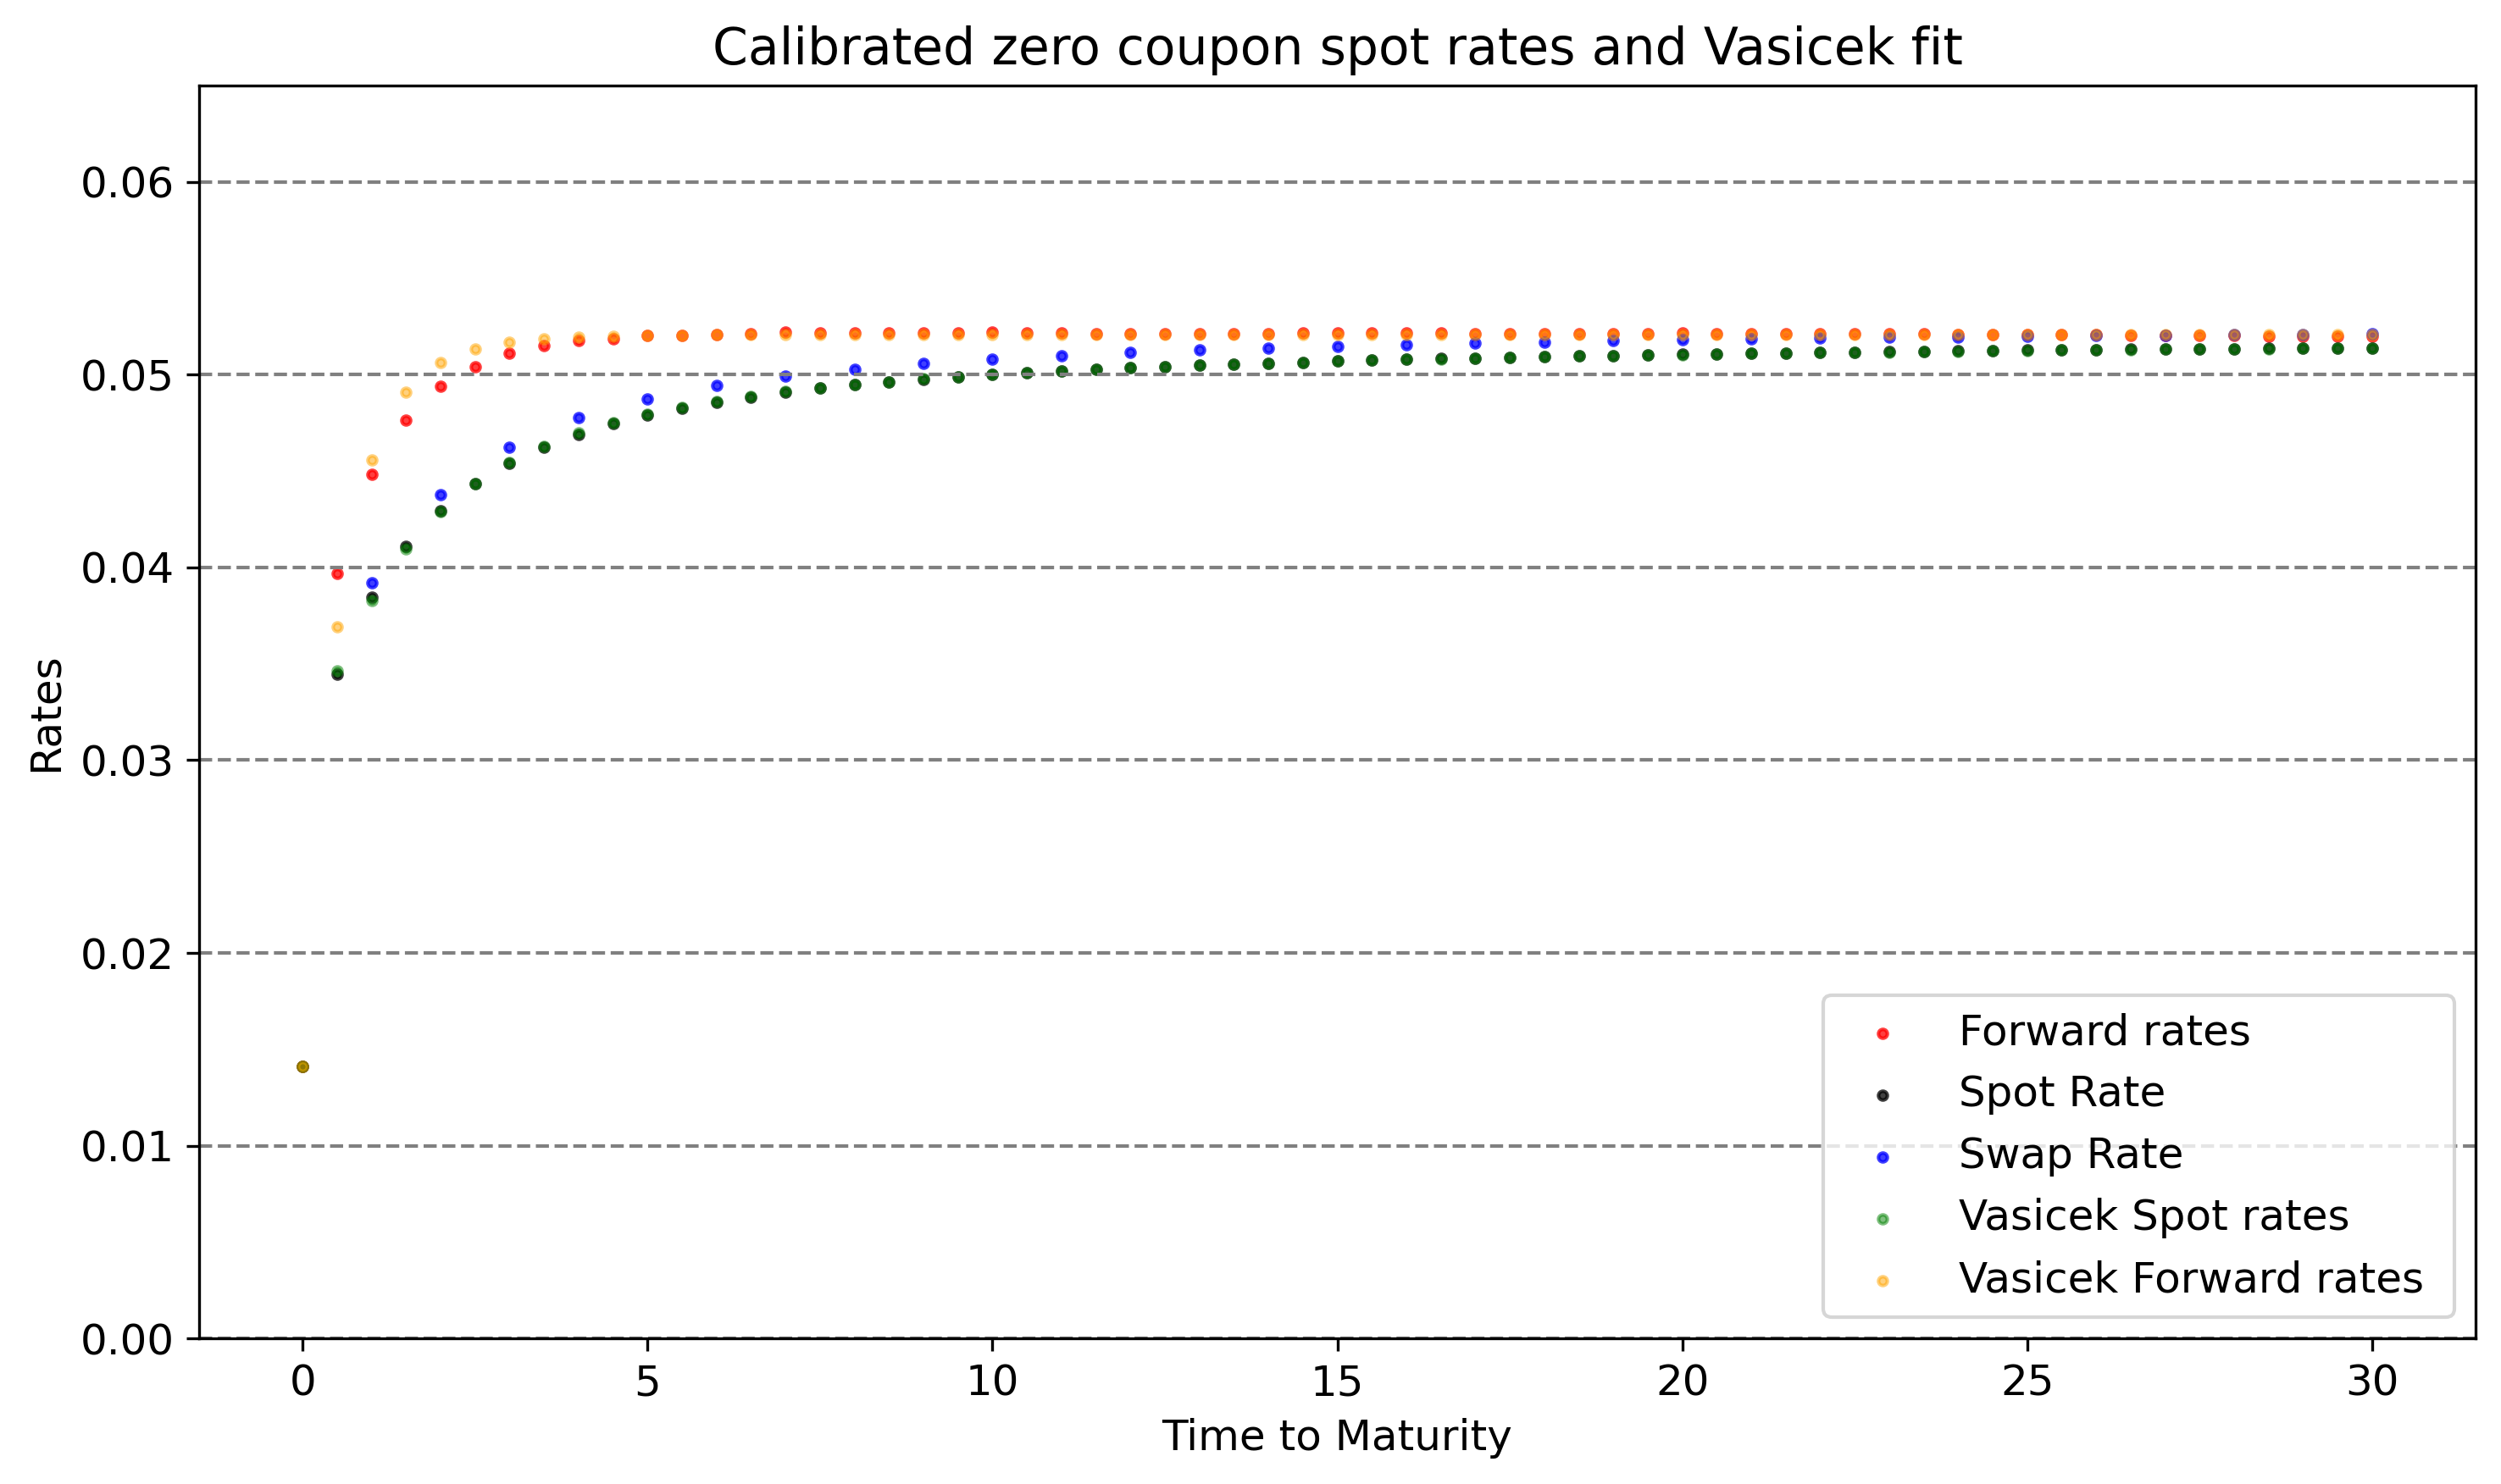

In [24]:
fit.append({'label':'Vasicek Spot rates', 'x':T_inter, 'y':R_vasicek,'color':'green','s':25,'alpha':0.5})
fit.append({'label':'Vasicek Forward rates', 'x':T_inter, 'y':f_vasicek,'color':'orange','s':25,'alpha':0.5})

plot.rates(fit,title='Calibrated zero coupon spot rates and Vasicek fit')

#### (c) Based on the quality of your fit, can you conclude that the short rate must follow a Vasicek model?
We see that the Vasicek model fits the data well, with the spot rates being spot on and the forward rates only being slightly above for the firt 3-4 years. However, this does not imply that the short rate must follow a Vasicek model. The Vasicek model is a simple one-factor model that assumes constant parameters over time, which may not accurately capture the dynamics of the short rate in practice. Other models like CIR, Hull-White, or more complex multi-factor models may provide better fits or capture additional features of the short rate term structure.